### Prepare space in flash

In [1]:
import os, subprocess

In [2]:
resultdir = os.path.join("/bucket/ReiterU/DBS/analysis/220824_sup_fig_atlas/")
if not os.path.exists(resultdir):
    subprocess.run(["ssh", "deigo", "mkdir", resultdir])

In [3]:
cwd = os.path.basename(os.getcwd())
tmpdir = os.path.join("/flash/ReiterU/tmp/", cwd, "overlay_brains")
if not os.path.exists(tmpdir):
    os.makedirs(tmpdir)

In [4]:
from probemapper.io import load_nifti, save_nifti
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import ndimage as ndi

### Load volume

In [5]:
ref = load_nifti("/bucket/ReiterU/DBS/data/20220526_P190_laqueus_DiI_L-F11/analysis/ants/O_Laqueues_v0.1_10um_masked.nii")
warped = load_nifti("/bucket/ReiterU/DBS/data/20220526_P190_laqueus_DiI_L-F11/analysis/ants/Warped.nii.gz")

ref = ref.astype("float")
warped = warped.astype("float")

# crop
ref = ref[70:, 30:440, 25:435]
warped = warped[70:, 30:440, 25:435]

In [6]:
def rotate_volume(vol, order=3):
    # rotation
    vol = ndi.rotate(vol, 225, axes=(0,1), reshape=False, order=order)
    vol = ndi.rotate(vol, 5, axes=(0,2), reshape=False, order=order)

    # flip
    vol = vol[:, ::-1, :]
    
    return vol

### NCC

In [7]:
from probemapper.registration.metric import NCC_3D

In [8]:
ncc = NCC_3D(ref, warped, ws=4)
ncc = rotate_volume(ncc)

In [9]:
mask = ref>0
mask = rotate_volume(mask, order=0)

In [10]:
ncc[~mask] = np.nan

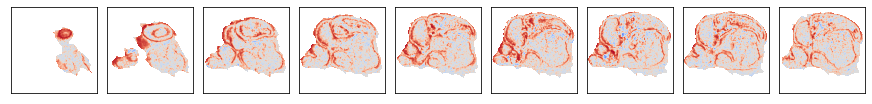

In [11]:
cmap = mpl.cm.get_cmap("coolwarm").copy()
cmap.set_bad("white")

fig, axs = plt.subplots(1,9, figsize=(12,5), constrained_layout=True)

for (i, sl) in enumerate(np.arange(70, 231, 20)):
    axs[i].imshow(ncc[:,:,sl], vmin=-1, vmax=1, cmap=cmap)
    #axs[i].axis("off")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#plt.savefig(os.path.join(tmpdir, "P190_NCC.png"), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(tmpdir, "P190_NCC.pdf"), dpi=300, bbox_inches="tight")
plt.show()

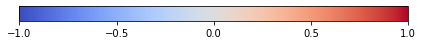

In [12]:
# Save the colorbar
fig = plt.figure(figsize=(6,2))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=cmap, norm=norm, ticks=[-1,-0.5,0,0.5,1])

plt.savefig(os.path.join(tmpdir, "colorbar.eps"), bbox_inches='tight')
plt.show()

### Overlay brains

In [13]:
def overlay_brains(im1, im2, vrange1, vrange2, gamma=1.0):
    rgb = np.zeros((*im1.shape, 3))
    # Magenta
    rgb[:,:,:,0] += 255 * (im1 - vrange1[0]) / (vrange1[1] - vrange1[0])
    rgb[:,:,:,2] += 255 * (im1 - vrange1[0]) / (vrange1[1] - vrange1[0])
    
    # Cyan
    rgb[:,:,:,1] += 255 * (im2 - vrange2[0]) / (vrange2[1] - vrange2[0])
    rgb[:,:,:,2] += 255 * (im2 - vrange2[0]) / (vrange2[1] - vrange2[0])
    # Gamma correction
    rgb = 255 * np.power(rgb/255, 1/gamma)

    return rgb.clip(0,255).astype("uint8")

In [14]:
ref2 = rotate_volume(ref)
warped2 = rotate_volume(warped)

In [15]:
rgb = overlay_brains(ref2, warped2, [0, 3000], [0,10000], gamma=1.8)

/home/t/tomoyuki-mano1/projects/probemapper/.env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


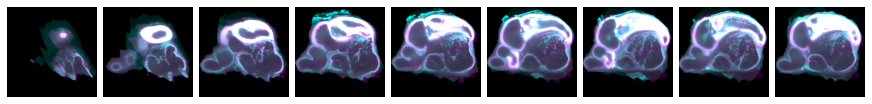

In [16]:
fig, axs = plt.subplots(1,9, figsize=(12,5), constrained_layout=True)

for (i, sl) in enumerate(np.arange(70, 231, 20)):
    axs[i].imshow(rgb[:,:,sl])
    axs[i].axis("off")

plt.savefig(os.path.join(tmpdir, "P190_overlay.pdf"), dpi=300, bbox_inches="tight")
plt.show()

### Show the warped grid

In [17]:
from probemapper.registration.qc import create_warped_grid_image

In [18]:
create_warped_grid_image("/apps/unit/ReiterU/ANTs/2.3.5/bin",
                         "/bucket/ReiterU/DBS/data/20220526_P190_laqueus_DiI_L-F11/analysis/ants/F2M_1Warp.nii.gz",
                         os.path.join(tmpdir, "warped_grid.nii.gz"),
                         directions="0x1x1", gs=150)

['/apps/unit/ReiterU/ANTs/2.3.5/bin/CreateWarpedGridImage', '3', '/bucket/ReiterU/DBS/data/20220526_P190_laqueus_DiI_L-F11/analysis/ants/F2M_1Warp.nii.gz', '/flash/ReiterU/tmp/220824_sup_fig_atlas/overlay_brains/warped_grid.nii.gz', '0x1x1', '150x150x150']

0


In [19]:
grid = load_nifti(os.path.join(tmpdir, "warped_grid.nii.gz"))
grid = grid[70:, 30:440, 25:435]
grid = rotate_volume(grid)

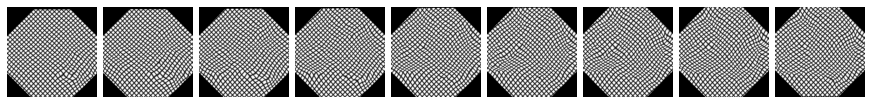

In [20]:
fig, axs = plt.subplots(1,9, figsize=(12,5), constrained_layout=True)

for (i, sl) in enumerate(np.arange(70, 231, 20)):
    axs[i].imshow(grid[:,:,sl], cmap="gray", vmin=0, vmax=255)
    axs[i].axis("off")

plt.savefig(os.path.join(tmpdir, "warped_grid.pdf"), dpi=300, bbox_inches="tight")
plt.show()

### Jacobian determinant

In [21]:
from probemapper.registration.qc import create_jacobian_determinant_image

In [28]:
create_jacobian_determinant_image("/apps/unit/ReiterU/ANTs/2.3.5/bin",
                                  "/bucket/ReiterU/DBS/data/20220526_P190_laqueus_DiI_L-F11/analysis/ants/F2M_1InverseWarp.nii.gz",
                                  os.path.join(tmpdir, "jacobian_determinant.nii.gz"))

['/apps/unit/ReiterU/ANTs/2.3.5/bin/CreateJacobianDeterminantImage', '3', '/bucket/ReiterU/DBS/data/20220526_P190_laqueus_DiI_L-F11/analysis/ants/F2M_1InverseWarp.nii.gz', '/flash/ReiterU/tmp/220824_sup_fig_atlas/overlay_brains/jacobian_determinant.nii.gz']

0


Colormap with [0,2] range

In [99]:
jacob = load_nifti(os.path.join(tmpdir, "jacobian_determinant.nii.gz"))
jacob = jacob[70:, 30:440, 25:435]
jacob = rotate_volume(jacob)
jacob[~mask] = np.nan

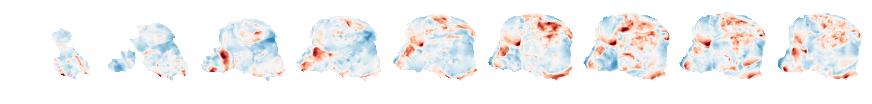

In [100]:
cmap = mpl.cm.get_cmap("RdBu_r").copy()
cmap.set_bad("white")

fig, axs = plt.subplots(1,9, figsize=(12,5), constrained_layout=True)

for (i, sl) in enumerate(np.arange(70, 231, 20)):
    axs[i].imshow(jacob[:,:,sl], vmin=0, vmax=2, cmap=cmap)
    axs[i].axis("off")

plt.savefig(os.path.join(tmpdir, "jacobian_determinant.pdf"), dpi=300, bbox_inches="tight")
plt.show()

Signed jacobian determinant

In [96]:
jacob = load_nifti(os.path.join(tmpdir, "jacobian_determinant.nii.gz"))
jacob = jacob[70:, 30:440, 25:435]
jacob = rotate_volume(jacob)
jacob[jacob < 1] = (-1) * (1.0 / jacob[jacob<1])
jacob[np.abs(jacob)<1.1] = 0
jacob[~mask] = np.nan

/home/t/tomoyuki-mano1/projects/probemapper/.env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


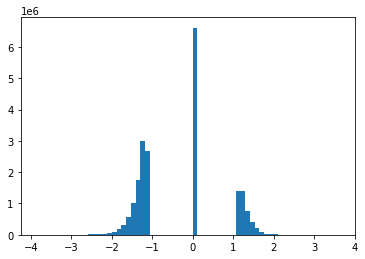

In [97]:
plt.hist(jacob.ravel(), bins=64)
plt.show()

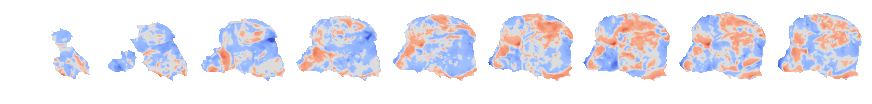

In [98]:
cmap = mpl.cm.get_cmap("coolwarm").copy()
cmap.set_bad("white")

fig, axs = plt.subplots(1,9, figsize=(12,5), constrained_layout=True)

for (i, sl) in enumerate(np.arange(70, 231, 20)):
    axs[i].imshow(jacob[:,:,sl], vmin=-3, vmax=3, cmap=cmap)
    axs[i].axis("off")

plt.savefig(os.path.join(tmpdir, "jacobian_determinant.pdf"), dpi=300, bbox_inches="tight")
plt.show()

### Copy data to bucket

In [101]:
subprocess.run(["scp", "-r", tmpdir, f"deigo:{resultdir}"])

CompletedProcess(args=['scp', '-r', '/flash/ReiterU/tmp/220824_sup_fig_atlas/overlay_brains', 'deigo:/bucket/ReiterU/DBS/analysis/220824_sup_fig_atlas/'], returncode=0)